<a href="https://colab.research.google.com/github/bernardooduarte/gestao-projetos-machine-learning/blob/main/C%C3%B3pia_de_04_Se%CC%81ries_temporais_com_o_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries temporais

Séries temporais tratam-se de registros que evoluem de acordo com uma sequência de tempo. As séries temporais estão presentes na grande maioria dos problemas que envolvem dados e é seguro dizer que a maior parte dos problemas que respolvemos com machine learning envolvem, de alguma forma, as séries temporais.

A previsão de séries temporais tem um nome muito usado em inglês, sendo inclusive utilizado em inúmeros materiais em outros idiomas: *forecast* ou *forecasting*. Entre problemas nos quais podemos aplicar machine learning e envolvem séries temporais (*forecasting*), temos:

*   Previsão de vendas: prever o volume de vendas no próximo dia, nos próximos 30 dias, no próximo ano, ou qualquer outro intervalo de tempo que seja interessante.

*   Variação no preço de uma ação nos próximos *n* dias.

*   Previsão da temperatura média, máxima, mínima, etc, pra os próximos *n* dias.

*   Número de veículos que irão trafegar por uma roda nos próximos *n* dias.

* Número de máquinas da fábrica que precisarão de manutenção no próximo semestre.

*   Outros inúmeros problemas

Como podemos ver nos exemplos acima, citamos 5 problemas de áreas totalmente distintas, o que nos dá uma ideia de quão diverso é o mundo das séries temporais. E se pensamos na ideia, prever valores no futuro faz total sentido no mundo de dados.

Além disso, devemos observar que a frequência que os dados de séries temporais são coletados variam de acordo com a ocasião. Os dados podem ser diários, mensais, anuais, assim como as previsões, as quais podem ser realizadas para diferentes horizontes de tempo.

Quando falamos de séries temporais, há sempre um tratamento que as separa dos demais problemas de machine learning. Porém, vale ressaltar neste ponto: modelos preditivos em séries temporais são modelos de regressão! Obviamente os modelos de séries temporais tem suas particularidas em relação aos prroblemas que não envolvem a variável do tempo, porém, no fim das contas, também buscam prever grandezas continuas baseadas em variáveis explicativas.

# Exemplo - Previsão de vendas

Neste exemplo temos um conjunto de dados de vendas, de diferentes lojas. Os dados desse exemplo são de um exemplo real e estão disponibilizados na plataforma Kaggle. Trata-se de farmácias e os dados de vendas medidos se referem a todos os produtos vendidos em cada dia. O objetivo de nosso modelo será prever as **vendas nos próximos 30 dias das 6 lojas com maior volume de vendas**. Para isso, além de informações das vendas históricas, teremos as informações históricas dos feriados, dias e dias promocionais, além dos feriados e dias promocionais previstos nos dias futuros que estamos prevendo.

Para isso, utilizaremos o framework Prophet, treinando o modelo  em cenários onde consideramos e não consideramos dias de feriados e dias de promoções nas lojas como variáveis do modelo. Para testar o funcionamento de nossos modelos, em um cenário o mais próximo possível da realidade, faremos a seguinte divisão dos dados:


*   Período de treinamento -> Todo o histórico até 2015-06.
*   Período de teste do modelo -> 2015-07.

Para verificar a performance de nosso modelo, utilizaremos o Erro médio absoluto (MAE, do inglês mean absolute error).



## Bibliotecas e configurações

In [4]:
# Bibliotecas e alguma configurações
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 200)
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Importando os dados
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = "/content/drive/MyDrive/Gestão de projetos em IA - Translator 5 - Aprofundamentos em Machine Learning/bases/"

Mounted at /content/drive


In [7]:
# Carregando os dados das vendas
# Fonte dos dados: https://www.kaggle.com/competitions/rossmann-store-sales/data
file_path = drive_path + "sales_rossmann.csv"
df_sales = pd.read_csv(file_path)
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_sales.head()

<ipython-input-7-71c9ce456b0a>:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sales = pd.read_csv(file_path)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


No dataframe, verificamos algumas colunas que serão importantes:
* Store - O ID único da loja para a qual vamos prever as vendas.
* Date - A data do registro.
* Sales - O volume de vendas na loja indicada.
* Open - Indica se a loja estava ou não estava aberta naquele dia.
* Promo - Indica se no dia indicado ocorreu alguma promoção.
* StateHoliday - Dias de feriado no país. Incluí feriados gerais (categoria "a"), feriado de páscoa (categoria "b) e feriado de natal (categoria "c"). Os dias anotados com "0" nessa coluna são dias sem feriado.
* SchoolHoliday - Dias de fechamento de escolas públicas.

In [8]:
# Agregando os valores de vendas para que tenhamos as vendas diárias de cada loja
df = df_sales.groupby(["Date", "Store"], as_index=False)["Sales"].sum()

In [9]:
df.groupby("Store")["Sales"].sum().sort_values(ascending=False)

,Sales
Store,
262,19516842
817,17057867
562,16927322
1114,16202585
251,14896870
...,...
263,2306075
208,2302052
198,2268273


# Predição para somente uma loja

Nesse primeiro teste, vamos fazer a previsão para somente uma loja, observando os detalhes das séries e dos resultados obtidos. para isso, vamos selecionar a loja com id=807, que é a loja com maior volume de vendas no período de dados que temos.

## Predição somente utilizando a própria série

Primeiramente, filtramos os dados de acordo com o que pensamos para o problema:
* Filtramos somente a loja de interesse.
* Separamos as bases de treinamento e validação, de acordo com as datas definidas acima.
* Renomeamos as colunas de "Date" e "Sales" para "ds" e "y" respectivamente, pois o Prophet exige que as colunas de data e a variável resposta tenham esses nomes.

In [10]:
store = 817 # Indicamos a loja para a qual faremos a previsão

# Filtramos o dataframe de treino para a loja indicada
df_train = df.loc[df['Store'] == store, ["Date", "Store", "Sales"]].copy()
df_train.drop(columns=['Store'], inplace=True)

# Renomeamos a coluna de data para "ds" e vendas para "y"
# Essa é uma necessidade para o treinamento de modelos utilizando o Prophet
df_train.rename(columns={"Date": "ds", "Sales": "y"}, inplace=True)

# Separamos o dataframe de validação e treino, de acordo com as datas desejada
df_valid = df_train.loc[(df_train['ds'] >= "2015-07-01") & (df_train['ds'] < "2015-08-01")].copy()
df_train = df_train.loc[(df_train['ds'] < "2015-07-01")].copy()

<Axes: xlabel='ds'>

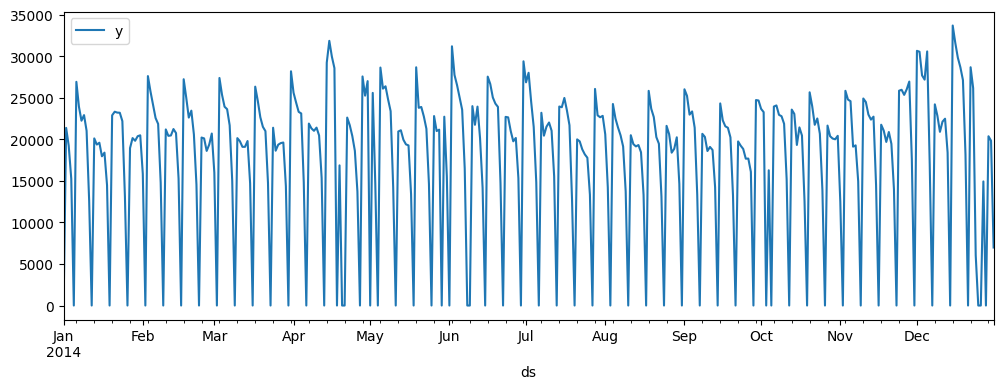

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
df_train.loc[
    (df_train["ds"] >= "2014-01-01") &
    (df_train["ds"] < "2015-01-01")
].set_index("ds").plot(ax=ax)

<Axes: xlabel='ds'>

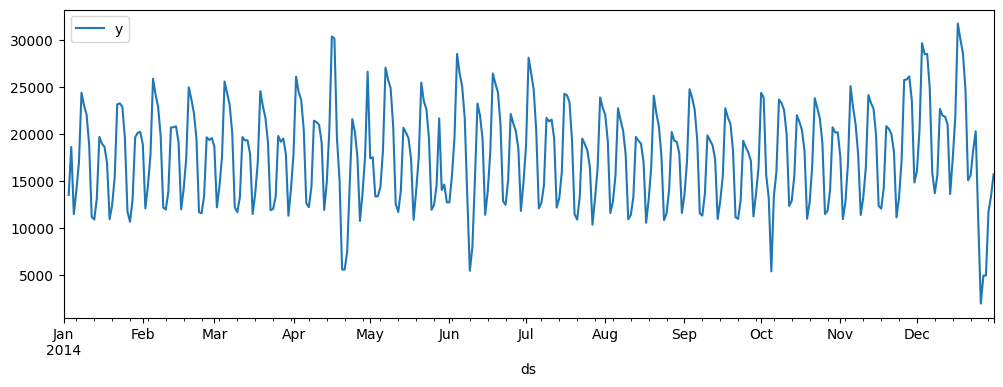

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
df_train.loc[
    (df_train["ds"] >= "2014-01-01") &
    (df_train["ds"] < "2015-01-01")
].set_index("ds").rolling(3).mean().plot(ax=ax)

<Axes: xlabel='ds'>

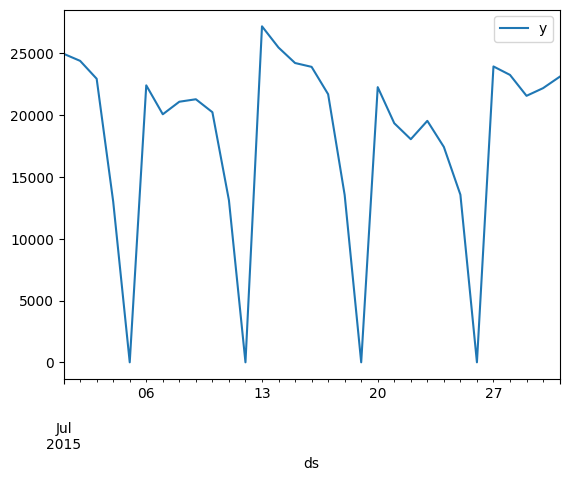

In [13]:
df_valid.set_index("ds").plot()

In [14]:
df_train.tail()

,ds,y
977885,2015-06-26,19273
979000,2015-06-27,13108
980115,2015-06-28,0
981230,2015-06-29,28456
982345,2015-06-30,27140


Após a preparação dos dados, treinamos o modelo Prophet, chamando o método "fit()" utilizando o dataframe de treino definido.


In [15]:
m = Prophet() # Instancia o modelo
m.fit(df_train) # Treina o modelo

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/9at41n_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/99t354v8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54335', 'data', 'file=/tmp/tmpyekvrjg3/9at41n_q.json', 'init=/tmp/tmpyekvrjg3/99t354v8.json', 'output', 'file=/tmp/tmpyekvrjg3/prophet_modelrvzaxddz/prophet_model-20250606182603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Por fim, faremos a previsão no período de validação, utilizando o modelo que foi treinado acima. Para isso, seguimos os seguintes passos:
* Criamos um dataframe chamado "future", com as datas para as quais fazemos a previsão.
* Fazemos a previsão através do método "predict()".
* Juntamos os dados preditos com os dados reais para verificar a performance do modelo.

In [16]:
# Criando o dataframe de previsão
start_date = "2015-07-01" # Data de início do período de validação
end_date = "2015-07-31" # Último dia do período de validação
date_range = pd.date_range(start_date, end_date, freq='d') # Cria um array com as datas
future = pd.DataFrame({'ds': date_range}) # Cria um dataframe com as datas
future.tail()

,ds
26,2015-07-27
27,2015-07-28
28,2015-07-29
29,2015-07-30
30,2015-07-31


In [17]:
forecast = m.predict(future) # Faz a previsão para o dataframe "future"
df_results = df_valid.merge(forecast[['ds', 'yhat']], on='ds', how='left') # União dos valores previstos com os valores reais
df_results.tail()

,ds,y,yhat
26,2015-07-27,23932,21472.191588
27,2015-07-28,23248,20777.233560
28,2015-07-29,21556,19446.267410
29,2015-07-30,22177,18522.965999
30,2015-07-31,23093,17905.336795


In [18]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
26,2015-07-27,16312.098655,15248.830878,26951.865408,16310.414230,16313.721664,5160.092934,5160.092934,5160.092934,6090.186261,6090.186261,6090.186261,-930.093327,-930.093327,-930.093327,0.0,0.0,0.0,21472.191588
27,2015-07-28,16308.778736,15489.504054,26614.547537,16306.889683,16310.528077,4468.454825,4468.454825,4468.454825,5419.835897,5419.835897,5419.835897,-951.381072,-951.381072,-951.381072,0.0,0.0,0.0,20777.233560
28,2015-07-29,16305.458817,13871.271796,25136.532370,16303.435218,16307.327604,3140.808593,3140.808593,3140.808593,4097.559424,4097.559424,4097.559424,-956.750831,-956.750831,-956.750831,0.0,0.0,0.0,19446.267410
29,2015-07-30,16302.138898,12577.049977,24240.316096,16299.864713,16304.218632,2220.827101,2220.827101,2220.827101,3167.142937,3167.142937,3167.142937,-946.315836,-946.315836,-946.315836,0.0,0.0,0.0,18522.965999
30,2015-07-31,16298.818979,12253.126293,23890.942579,16296.405065,16301.062285,1606.517816,1606.517816,1606.517816,2527.074160,2527.074160,2527.074160,-920.556344,-920.556344,-920.556344,0.0,0.0,0.0,17905.336795


Como podemos observar no dataframe "forecast", o Prophet nos retorna diversas componentes relacionadas a componentes do modelo, tendência e intervalos de predição. Porém, vale destacar 3 componentes principais:

* yhat - O valor previsto.
* yhat_lower - Valor inferior de um intervalo de predição calculado pelo Prophet.
* yhat_upper - Valor superior de um intervalo de predição calculado pelo Prophet.

Com as 3 componentes acima, podemos observar não somente o valor mais provável previsto, porém também podemos contar com um intervalo de confiança para esse valor previsto.

Para nossas análises de erro e visualização dos resultados, seguiremos somente com o valor de "yhat".

Abaixo, calculamos o primeiro valor do MAE e visualizamos os resultados comparados dia a dia, no período de validação.

In [19]:
# Cálculo do erro médio absoluto
mae = np.round(mean_absolute_error(df_results["y"], df_results["yhat"]), 2)
print("Erro médio absoluto (MAE):", mae)

Erro médio absoluto (MAE): 2106.67


<Axes: xlabel='ds'>

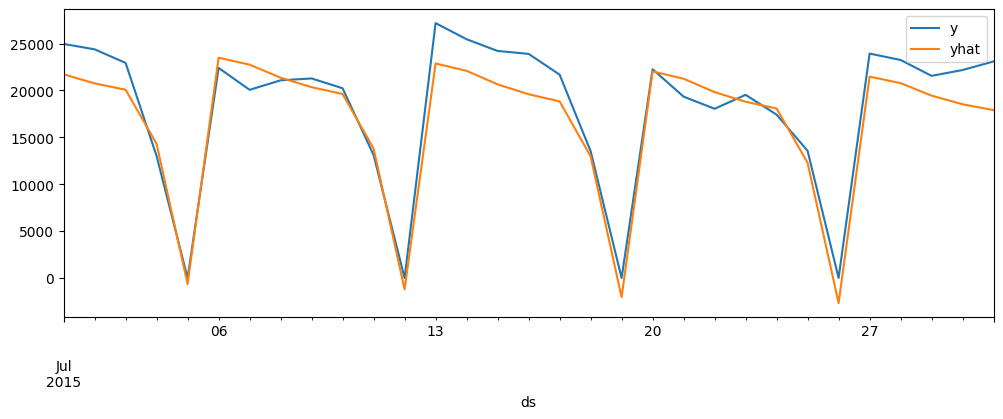

In [20]:
# plota os resultados ao longo do tempo
fig, ax = plt.subplots(figsize=(12, 4))
df_results.set_index('ds').plot(ax=ax)

Nota-se que o erro médio é de aproximadamente 2107 unidades do produto. Porém, mas além disso cabe destacar que o modelo conseguiu seguir muito bem a tendência das vendas, capturando muito bem as características sazonais das vendas de produtos nessa loja.

Nota-se, porém, que o modelo apresenta certas dificuldades, principalmente nos picos de vendas.

É um resultado bastante satisfatório que conseguimos com algumas linhas de código!

# EXTRA

## Adicionando os feriados

Na busca de tentar melhorar nossas previsões, vamos indicar os feriados que tivemos no período de treinamento e também os feriados que teremos nos dias de validação. Os feriados entraram como variáveis explicativas explicativas no Prophet.

Importante ressaltar: **assumimos que no planejamento já sabemos os dias que serão feriados e também os feriados nos quais as lojas estarão fechadas!**

Para indicar os feriados ao Prophet, é necessário que, ao instanciar o modelo, o usuário indique a lista de dias com feriados que teremos na loja. Essa lista tem que ser incluída em um dataframe que terá duas colunas:
* ds - Indica a data do feriado.
* holiday - Indica o nome do feriado.

Como temos diferentes feriados em nosso dataframe (páscoa, natal e nacionais), vamos criar um dataframe para cada tipo de feriado. Após isso, juntaremos os dataframes e criaremos o dataframe final que passaremos ao Prophet.

Como essa é uma sequência de passos que vamos repetir abaixo, vamos criar uma função que cria esse dataframe para uma loja indicada.


In [21]:
df_sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Como observamos na descrição dos dados acima, temos as indicações de feriados, promoções e dias que as lojas abriram. Utilizaremos essas colunas na função para a criação do dataframe dos feriados.

In [22]:
def generate_holidays_df(df_sales, store, promo=False):
  """
  Cria um dataframe (df_holidays) que indica os feriados para uma loja específica.
  O dataframe irá conter duas colunas:
  - ds - Data do feriado.
  - holiday - Descrição do feriado

  Parâmetros:
  - df_sales - Dataframe que contém a coluna que indica as lojas, feriados, dias de promoção e dias que as lojas estiveram abertas.
  - store - Loja para a qual se deseja criar um dataframe dos feriados.
  - promo - Indica se incluíremos os dias de promoção na loja como feriados.
  """
  list_df_holidays = [] # Lista auxiliar para guardar os dafataframes dos feriados
  holidays_list = [i for i in df_sales["StateHoliday"].astype(str).unique() if i!= '0'] # Lista de feriados válidos
  # No loop abaixo criamos os dataframes dos feriados registrados e previstos para a loja
  for hol in holidays_list:
    # Caso seja data de feriado e a loja for de fato ficar fechada, guardamos a data do feriado
    df_state = df_sales.loc[(df_sales['Store'] == store) & (df_sales["StateHoliday"] == hol) & (df_sales["Open"] == 0), ["Date"]].copy()
    df_state["holiday"] = f"state_holiday_{hol}" # Indica o tipo do feriado
    df_state.columns = ["ds", "holiday"]
    df_state.drop_duplicates(inplace=True)
    list_df_holidays.append(df_state) # Adiciona o dataframe com as datas dos feriados a lista

  # Caso seja data de feriado escolar e a loja for de fato ficar fechada, guardamos a data do feriado
  df_school = df_sales.loc[(df_sales['Store'] == store) & (df_sales["SchoolHoliday"] == 1) & (df_sales["Open"] == 0), ["Date"]].copy()
  df_school["holiday"] = "school_holiday" # Indica o tipo do feriado
  df_school.columns = ["ds", "holiday"]
  df_school.drop_duplicates(inplace=True)
  list_df_holidays.append(df_school) # Adiciona o dataframe com as datas dos feriados a lista

  # Caso a ideia seja indicar também os dias promocionais, entra na condição abaixo
  if promo==True:
    # Caso seja data de promoção e a loja for de fato ficar aberta, guardamos a data do dia promocional
    df_promo = df_sales.loc[(df_sales['Store'] == store) & (df_sales["Promo"] == 1) & (df_sales["Open"] == 1), ["Date"]].copy()
    df_promo["holiday"] = "promo_day" # Indica o tipo de data promocional
    df_promo.columns = ["ds", "holiday"]
    df_promo.drop_duplicates(inplace=True)
    list_df_holidays.append(df_promo) # Adiciona o dataframe com as datas dos feriados a lista

  df_holidays = pd.concat(list_df_holidays) # Concatena todos os dataframes criados
  return df_holidays

Abaixo, criamos o dataframe com os feriados e treinamos o modelo com os feriados indicados. Para isso, basta passar o novo dataframe ao parâmetro "holidays" do Prophet.

In [23]:
df_holidays = generate_holidays_df(df_sales, store, promo=False) # Executa a função e cria o dataframe dos feriados
m = Prophet(holidays=df_holidays) # Instancia o modelo
m.fit(df_train) # Treina o modelo

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/6kg_jltg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/bwyj2ofw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42322', 'data', 'file=/tmp/tmpyekvrjg3/6kg_jltg.json', 'init=/tmp/tmpyekvrjg3/bwyj2ofw.json', 'output', 'file=/tmp/tmpyekvrjg3/prophet_modelho1pq9j6/prophet_model-20250606182604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [24]:
# Exibe algunas linhas do dataframe holidays, como exemplo
df_holidays.sample(10)

,ds,holiday
133501,2015-04-03,state_holiday_b
490631,2014-04-18,school_holiday
861926,2013-05-20,state_holiday_a
236081,2015-01-01,state_holiday_a
710286,2013-10-03,state_holiday_a
444916,2014-05-29,state_holiday_a
242669,2014-12-25,school_holiday
617741,2013-12-25,school_holiday
133501,2015-04-03,school_holiday
476136,2014-05-01,state_holiday_a


In [25]:
forecast = m.predict(future) # Faz a previsão para o dataframe "future"
df_results = df_valid.merge(forecast[['ds', 'yhat']], on='ds', how='left') # União dos valores previstos com os valores reais
df_results.tail()

,ds,y,yhat
26,2015-07-27,23932,22293.121039
27,2015-07-28,23248,20616.176183
28,2015-07-29,21556,19621.166810
29,2015-07-30,22177,19577.534868
30,2015-07-31,23093,18609.485403


In [26]:
# Cálculo do erro médio absoluto
mae = np.round(mean_absolute_error(df_results["y"], df_results["yhat"]), 2)
print("Erro médio absoluto (MAE):", mae)

Erro médio absoluto (MAE): 1938.95


<Axes: xlabel='ds'>

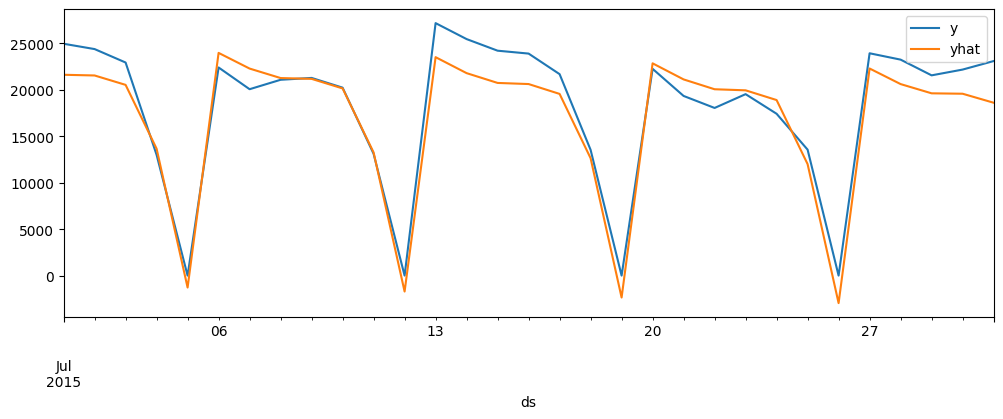

In [27]:
# Plota os resultados ao longo do tempo
fig, ax = plt.subplots(figsize=(12, 4))
df_results.set_index('ds').plot(ax=ax)

Nota-se que o erro médio é de aproximadamente 1938 unidades do produto. Já houve uma melhora considerável no erro do modelo (cerca de 8% de redução no erro)

Segue sendo um bom resultado, principalmente observando que o Prophet está capturando bem a tendência. Porém, ainda com algumas dificuldades nos dias com mais vendas.

## Adicionando os dias de promoção

A última etapa de melhoria de nosso modelo será a adição dos dias de promoção.

Aqui cabe outro grande alerta: estamos assumindo que, segundo o planejamento das ações da loja, **sabemos exatamente em que dias teremos promoções nos próximos 30 dias**. Assim, podemos adicionar os eventos de promoções como variáveis do Prophet. Caso não haja essa informação dos eventos promocionais que teremos para os dias que vamos fazer as previsões, não seria possível utilizar esses dados.

Adicionaremos os dias promocionais como "feriados" ao Prophet. O Prophet utiliza o parâmetro de "holiday" para indicar dias atípicos no volume de vendsa das lojas, onde ocorrerão variações atípicas, seja para mais ou para menos. Então, apesar de ser um parâmetro para indicar feriados, podemos indicar eventos como dias promocionais que o Prophet interpretará devidamente.

Como já criamos nossa função auxiliar acima, para adicionar os dias promocionais basta atualizar o parâmetro "promo" da função.

In [28]:
df_holidays = generate_holidays_df(df_sales, store, promo=True) # Executa a função e cria o dataframe dos feriados
m = Prophet(holidays=df_holidays) # Instancia o modelo
m.fit(df_train) # Treina o modelo

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/lupl3zvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/y0l11o11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43324', 'data', 'file=/tmp/tmpyekvrjg3/lupl3zvr.json', 'init=/tmp/tmpyekvrjg3/y0l11o11.json', 'output', 'file=/tmp/tmpyekvrjg3/prophet_model84lkoafn/prophet_model-20250606182605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:26:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
forecast = m.predict(future) # Faz a previsão para o dataframe "future"
df_results = df_valid.merge(forecast[['ds', 'yhat']], on='ds', how='left') # União dos valores previstos com os valores reais
df_results.tail()

,ds,y,yhat
26,2015-07-27,23932,24104.828546
27,2015-07-28,23248,22543.147971
28,2015-07-29,21556,21571.029843
29,2015-07-30,22177,21441.892154
30,2015-07-31,23093,20645.725373


In [30]:
# Cálculo do erro médio absoluto
mae = np.round(mean_absolute_error(df_results["y"], df_results["yhat"]), 2)
print("Erro médio absoluto (MAE):", mae)

Erro médio absoluto (MAE): 1207.88


<Axes: xlabel='ds'>

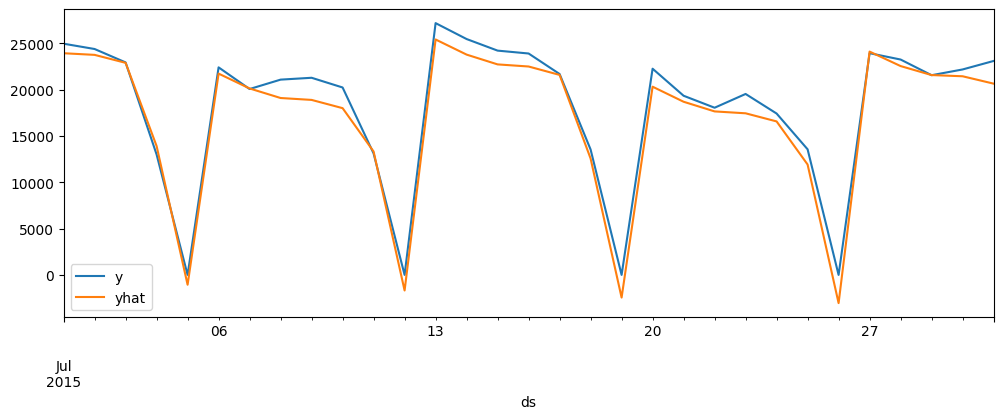

In [31]:
# Plota os resultados ao longo do tempo
fig, ax = plt.subplots(figsize=(12, 4))
df_results.set_index('ds').plot(ax=ax)

Nota-se que o erro médio é de aproximadamente 1208 unidades do produto. Hounve uma grande melhora no erro absoluto, com uma redução superior a 38% do erro que tínhamos na etapa anterior.

Este resultado nos indica que há uma forte relação dos dias promocionais com as vendas para este problema específico que estamos analisando.

Nota-se, principalmente, que o modelo aproximou melhor as previsões nos picos de vendas.

# Previsão para mais de uma loja

Vamos seguir com um exemplo para a previsão das 6 lojas com maior volume de vendas.

Para realizar a previsão, vamos treinar um modelo específico para cada loja. Para isso, vamos utilizar um for loop, seguir o mesmo passo de treinamento para cada passo do loop e, por fim, unir os resultados em um dataframe único.

In [32]:
# Gerando uma lista com as 6 lojas com maior volume de vendas no histórico
lista_top = df.groupby("Store")["Sales"].sum().sort_values(ascending=False).head(6).index.tolist()
lista_top

[262, 817, 562, 1114, 251, 513]

In [33]:
# Separação dos dados de treino e validação, considerando as lojas top6
df_train = df.loc[df['Store'].isin(lista_top), ["Date", "Store", "Sales"]].copy()
df_train.rename(columns={"Date": "ds", "Sales": "y"}, inplace=True)
df_valid = df_train.loc[(df_train['ds'] >= "2015-07-01") & (df_train['ds'] < "2015-08-01")].copy()
df_train = df_train.loc[(df_train['ds'] < "2015-07-01")].copy()

## Predição somente utilizando a própria série

Abaixo é feito o treinamento e a previsão para cada loja, utilizando um for loop.

In [34]:
lista_dfs = []
for store in lista_top:
  df_train_item = df_train.loc[df_train["Store"] == store, :] # Seleciona somente dados de treino da loja atual
  df_train_item.drop(columns=['Store'], inplace=True)
  df_valid_item = df_valid.loc[df_valid["Store"] == store, :] # Seleciona somente dados de validação da loja atual
  df_valid_item.drop(columns=['Store'], inplace=True)
  m = Prophet() # Instancia o modelo
  m.fit(df_train_item) # Treina o modelo
  future_item = future.merge(df.loc[df['Store'] == store, :], left_on="ds", right_on="Date")[["ds"]]
  forecast = m.predict(future_item) # Faz a previsão para a loja atual
  df_valid_item = df_valid_item.merge(forecast[['ds', 'yhat']], on='ds', how='left') # União dos resultados com os dados reais
  df_valid_item["Store"] = store
  lista_dfs.append(df_valid_item) # Adiciona a previsão da loja a lista que contém todos os dataframes de previsão

<ipython-input-34-8b67340b0923>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_item.drop(columns=['Store'], inplace=True)
<ipython-input-34-8b67340b0923>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_item.drop(columns=['Store'], inplace=True)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/p8c5cp4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/4x3hn1q2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dis

In [35]:
# Concatenando os resultados para cada uma das lojas
df_results = pd.concat(lista_dfs)
df_results.head()

,ds,y,yhat,Store
0,2015-07-01,21418,17596.638313,262
1,2015-07-02,21564,18559.413447,262
2,2015-07-03,23253,20032.132394,262
3,2015-07-04,17090,16341.360795,262
4,2015-07-05,30255,27149.479894,262


In [36]:
# Erro médio absoluto para todo o dataset, com todas as lojas
mae = np.round(mean_absolute_error(df_results["y"], df_results["yhat"]), 2)
print("Erro médio absoluto (MAE):", mae)

Erro médio absoluto (MAE): 2138.32


In [37]:
dict_mae_1 = {}
for store in lista_top:
  mae = np.round(
      mean_absolute_error(
          df_results.loc[df_results["Store"] == store, "y"], df_results.loc[df_results["Store"] == store, "yhat"]
      ), 2
      )
  dict_mae_1[store] = mae
  print("Loja: ", store)
  print("Erro médio absoluto (MAE):", mae)
  print("\n")

Loja:  262
Erro médio absoluto (MAE): 2266.43


Loja:  817
Erro médio absoluto (MAE): 2106.67


Loja:  562
Erro médio absoluto (MAE): 1421.07


Loja:  1114
Erro médio absoluto (MAE): 2750.63


Loja:  251
Erro médio absoluto (MAE): 2172.31


Loja:  513
Erro médio absoluto (MAE): 2112.79




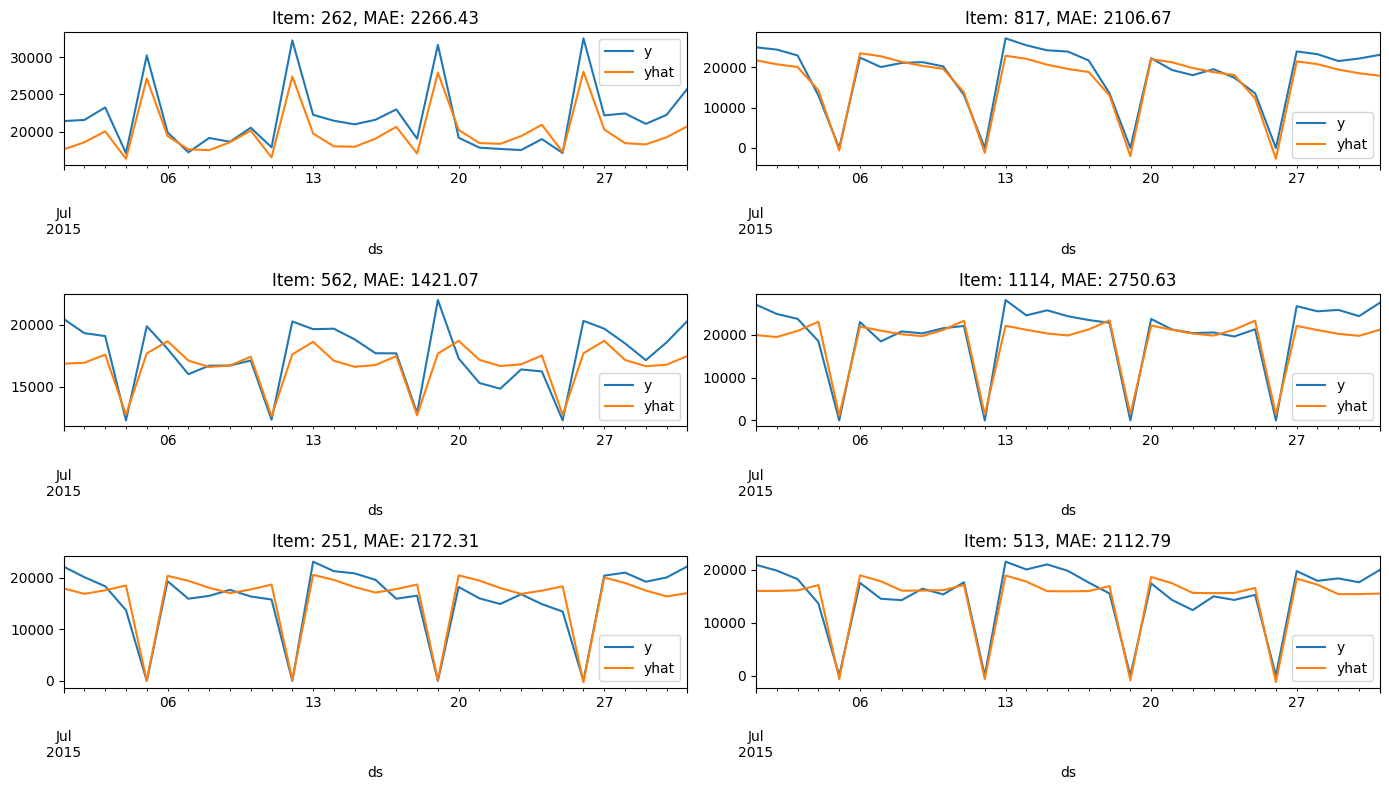

In [38]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
fax = ax.ravel()
for i in range(0, 6):
  mae = dict_mae_1[lista_top[i]]
  df_results.loc[df_results["Store"] == lista_top[i]].set_index('ds')[["y", "yhat"]].plot(ax=fax[i])
  fax[i].set_title(f"Item: {str(lista_top[i])}, MAE: {mae}")
plt.tight_layout()

## Adicionando os feriados

Da mesma forma que fizemos para o caso de somente uma loja, adicionamos os feriados na previsão para múltiplas lojas.

In [39]:
lista_dfs = []
for store in lista_top:
  df_train_item = df_train.loc[df_train["Store"] == store, :]
  df_train_item.drop(columns=['Store'], inplace=True)
  df_valid_item = df_valid.loc[df_valid["Store"] == store, :]
  df_valid_item.drop(columns=['Store'], inplace=True)
  df_holidays = generate_holidays_df(df_sales, store, promo=False)
  m = Prophet(holidays=df_holidays)
  m.fit(df_train_item)
  future_item = future.merge(df.loc[df['Store'] == store, :], left_on="ds", right_on="Date")[["ds"]]
  forecast = m.predict(future_item)
  df_valid_item = df_valid_item.merge(forecast[['ds', 'yhat']], on='ds', how='left')
  df_valid_item["Store"] = store
  lista_dfs.append(df_valid_item)

<ipython-input-39-9248ab5acbeb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_item.drop(columns=['Store'], inplace=True)
<ipython-input-39-9248ab5acbeb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_item.drop(columns=['Store'], inplace=True)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/x4sjwyle.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/qsfgwpmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dis

In [40]:
df_results = pd.concat(lista_dfs)
df_results.head()

,ds,y,yhat,Store
0,2015-07-01,21418,17596.638313,262
1,2015-07-02,21564,18559.413447,262
2,2015-07-03,23253,20032.132394,262
3,2015-07-04,17090,16341.360795,262
4,2015-07-05,30255,27149.479894,262


In [41]:
mae = np.round(mean_absolute_error(df_results["y"], df_results["yhat"]), 2)
print("Erro médio absoluto (MAE):", mae)

Erro médio absoluto (MAE): 2032.41


In [42]:
dict_mae_2 = {}
for store in lista_top:
  mae = np.round(
      mean_absolute_error(
          df_results.loc[df_results["Store"] == store, "y"], df_results.loc[df_results["Store"] == store, "yhat"]
      ), 2
      )
  dict_mae_2[store] = mae
  print("Loja: ", store)
  print("Erro médio absoluto (MAE):", mae)
  print("\n")

Loja:  262
Erro médio absoluto (MAE): 2266.43


Loja:  817
Erro médio absoluto (MAE): 1938.95


Loja:  562
Erro médio absoluto (MAE): 1421.07


Loja:  1114
Erro médio absoluto (MAE): 2387.56


Loja:  251
Erro médio absoluto (MAE): 2133.19


Loja:  513
Erro médio absoluto (MAE): 2047.23




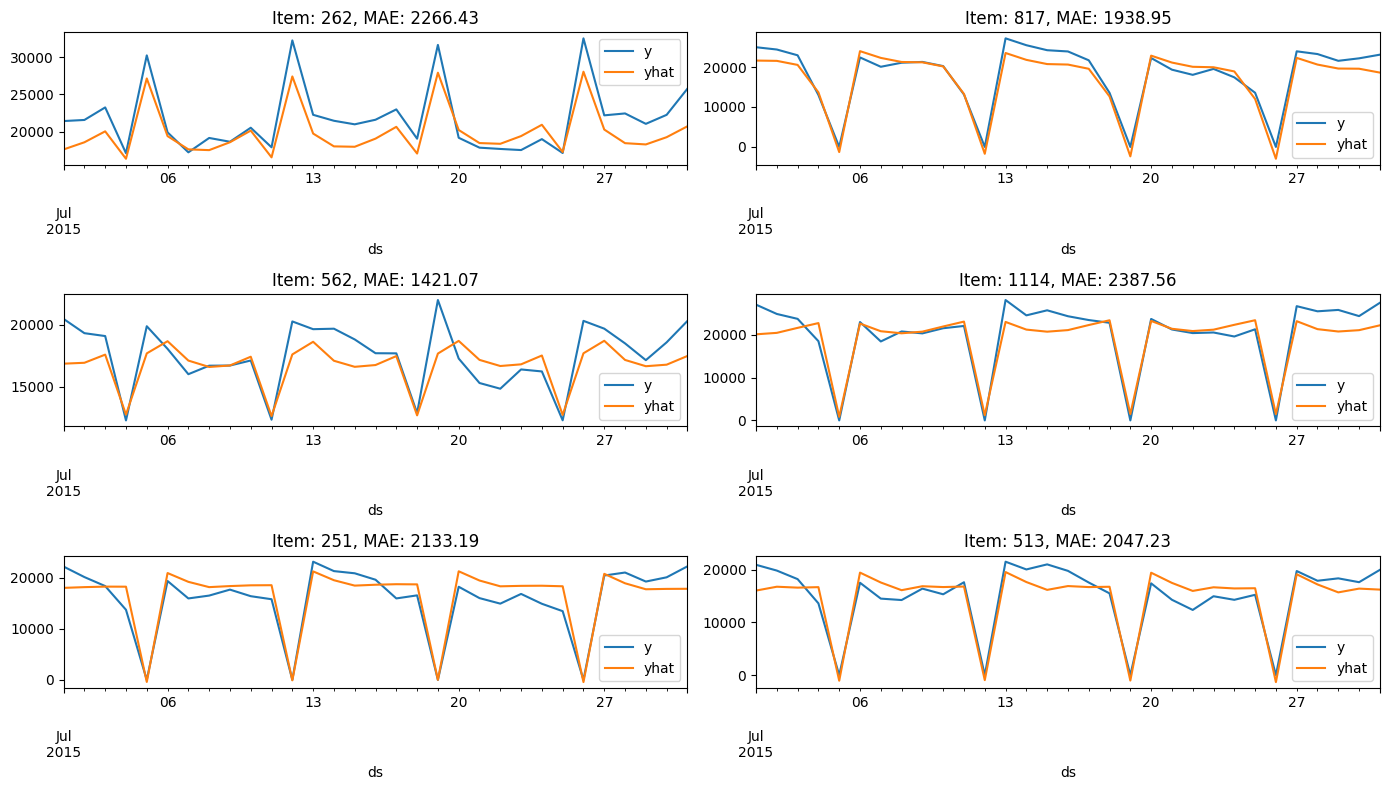

In [43]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
fax = ax.ravel()
for i in range(0, 6):
  mae = dict_mae_2[lista_top[i]]
  df_results.loc[df_results["Store"] == lista_top[i]].set_index('ds')[["y", "yhat"]].plot(ax=fax[i])
  fax[i].set_title(f"Item: {str(lista_top[i])}, MAE: {mae}")
plt.tight_layout()

## Adicionando os dias de promoção

In [44]:
lista_dfs = []
for store in lista_top:
  df_train_item = df_train.loc[df_train["Store"] == store, :]
  df_train_item.drop(columns=['Store'], inplace=True)
  df_valid_item = df_valid.loc[df_valid["Store"] == store, :]
  df_valid_item.drop(columns=['Store'], inplace=True)
  df_holidays = generate_holidays_df(df_sales, store, promo=True)
  m = Prophet(holidays=df_holidays)
  m.fit(df_train_item)
  future_item = future.merge(df.loc[df['Store'] == store, :], left_on="ds", right_on="Date")[["ds"]]
  forecast = m.predict(future_item)
  df_valid_item = df_valid_item.merge(forecast[['ds', 'yhat']], on='ds', how='left')
  df_valid_item["Store"] = store
  lista_dfs.append(df_valid_item)

<ipython-input-44-4258d934ee75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_item.drop(columns=['Store'], inplace=True)
<ipython-input-44-4258d934ee75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_item.drop(columns=['Store'], inplace=True)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/qb0wlng5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyekvrjg3/na0p_k49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dis

In [45]:
df_results = pd.concat(lista_dfs)
df_results.head()

,ds,y,yhat,Store
0,2015-07-01,21418,18943.178396,262
1,2015-07-02,21564,19896.518767,262
2,2015-07-03,23253,21356.969580,262
3,2015-07-04,17090,16443.111980,262
4,2015-07-05,30255,27234.714005,262


In [46]:
mae = np.round(mean_absolute_error(df_results["y"], df_results["yhat"]), 2)
print("Erro médio absoluto (MAE):", mae)

Erro médio absoluto (MAE): 1410.58


In [47]:
dict_mae_3 = {}
for store in lista_top:
  mae = np.round(
      mean_absolute_error(
          df_results.loc[df_results["Store"] == store, "y"], df_results.loc[df_results["Store"] == store, "yhat"]
      ), 2
      )
  dict_mae_3[store] = mae
  print("Loja: ", store)
  print("Erro médio absoluto (MAE):", mae)
  print("\n")

Loja:  262
Erro médio absoluto (MAE): 1875.0


Loja:  817
Erro médio absoluto (MAE): 1207.88


Loja:  562
Erro médio absoluto (MAE): 1078.07


Loja:  1114
Erro médio absoluto (MAE): 1870.57


Loja:  251
Erro médio absoluto (MAE): 1397.28


Loja:  513
Erro médio absoluto (MAE): 1034.65




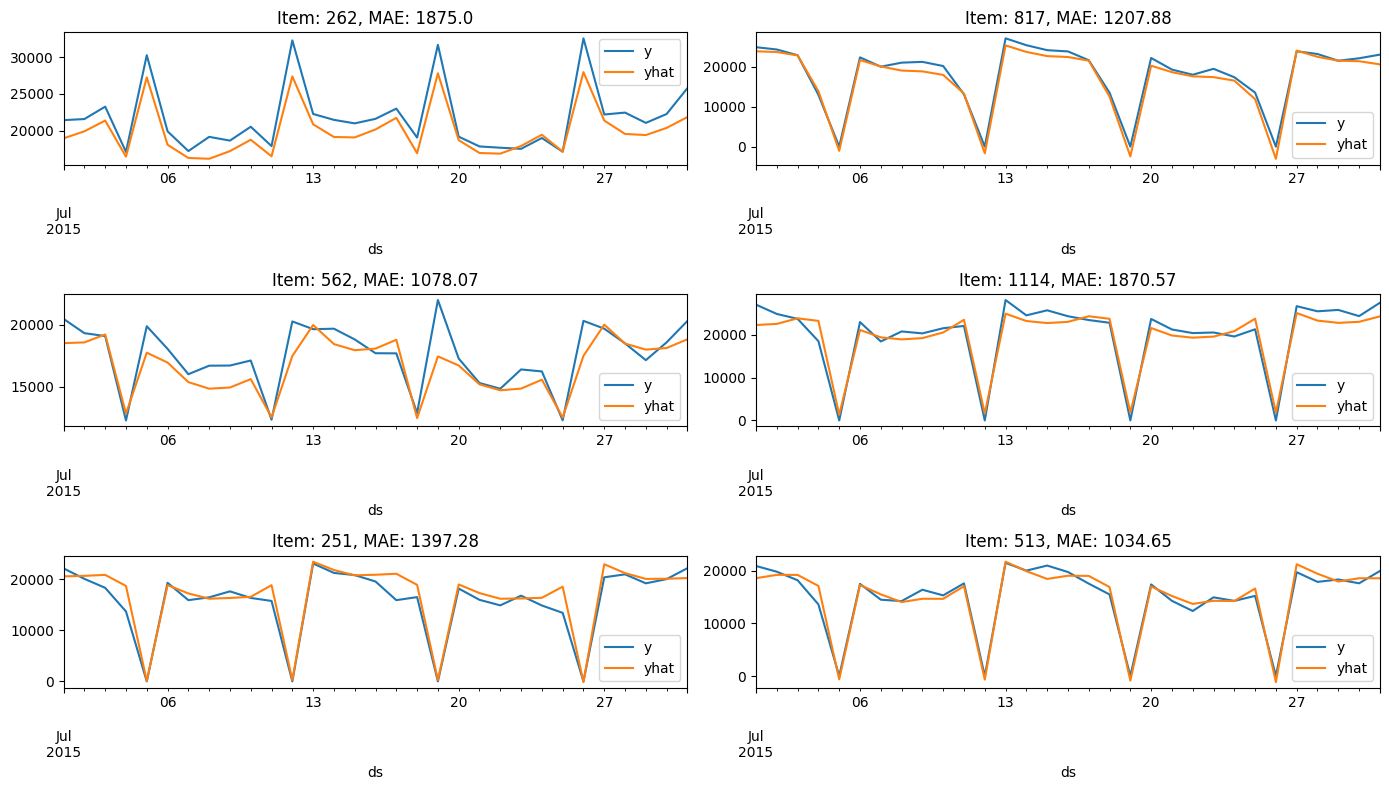

In [48]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
fax = ax.ravel()
for i in range(0, 6):
  mae = dict_mae_3[lista_top[i]]
  df_results.loc[df_results["Store"] == lista_top[i]].set_index('ds')[["y", "yhat"]].plot(ax=fax[i])
  fax[i].set_title(f"Item: {str(lista_top[i])}, MAE: {mae}")
plt.tight_layout()

## Comparando os resultados

In [49]:
df_1 = pd.DataFrame({"Store": dict_mae_1.keys(), "MAE V0": dict_mae_1.values()})
df_2 = pd.DataFrame({"Store": dict_mae_2.keys(), "MAE com feriado": dict_mae_2.values()})
df_3 = pd.DataFrame({"Store": dict_mae_3.keys(), "MAE com promo": dict_mae_3.values()})
df_mae_final = pd.concat([df_1, df_2["MAE com feriado"], df_3["MAE com promo"]], axis=1)
df_mae_final

,Store,MAE V0,MAE com feriado,MAE com promo
0,262,2266.43,2266.43,1875.00
1,817,2106.67,1938.95,1207.88
2,562,1421.07,1421.07,1078.07
3,1114,2750.63,2387.56,1870.57
4,251,2172.31,2133.19,1397.28
5,513,2112.79,2047.23,1034.65
